In [12]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [13]:
import joblib
from skimage.io import imread
from skimage.transform import resize
import pickle
# (10 pkt.)
# Funkcja do przerabiania obrazków na dane wejściowe 


# Output - Słownik z przerobionymi obrazami na dane wejściowe zapisz do pliku 
# [nazwa]_[szerokosc]x[wysokosc]px.pkl - aby na przyszlosc pamietac, do jakich rozmiarow zmienilismy obrazki

def resize_all(src, pklname, include, width=150, height=None):
    """
      
    Parameter
    ---------
    src: str
        ściezka do folderu głównego z obrazkami
    pklname: str
        nazwa pliku wyjściowego
    width: int
        docelowa szerokość obrazków 
    include: set[str]
        set zawierający nazwy klas, które chcemy dodać
    """
    # Jeśli height nie jest zdefiniowane to przyjmujemy, ze obraz jest kwadratem
    height = 80
     
    data = {}
    data['description'] = []
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
    
    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir, dirs, files in os.walk(src):
        for dir in dirs:
            if dir in include:
                for subdir2, dirs2, files2 in os.walk(src+'/'+dir):
                    for file in files2:
                        # print(file)
                        if(file.lower().endswith(('.jpg', 'jpeg'))):
                            data['description'].append("W tm pliku są djęcia z folderu {dirs2} o rozmiarze {width}x{height}")
                            data['label'].append(dir)
                            data['filename'].append(file)
                            data['data'].append(resize(imread(src+'/'+dir+'/'+file),(height, height))) 
    with open('output.pickle', 'wb') as output:
        pickle.dump(data, output)
    # print(data)
                # for img in files:
                #     if img.lower().endswith('.jpg'):
                #         print(img)
 
    # Przechodzimy się po folderze głownym
    # Nastepnie przechodzimy się po folderach wewnątrz
    # Nastepnie przechodzimy się po zdjęciach
    # Jeśli zdjęcie jest jpg lub png
    # to Dzialamy na nie funkcją imread
    # potem dzialamy funkcją resize
    # Do słownika dodajemy nazwę klasy
    # Do słownika dodajemy nazwę pliku
    # Do słownika dodajemy odczytany i pomniejszony obraz
    # Cały słownik "piklujemy"
resize_all('Image', 'output', ['CatHead', 'CowHead'])

   
   

In [14]:
# (5 pkt.)

pkl_name = 'output'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
resize_all('Image', pkl_name, include)
# wywołaj funkcję - resize_all


In [15]:
from collections import Counter
# (5 pkt.)
# Załaduj "zapiklowany" plik
with open('output.pickle', 'rb') as input:
    data = pickle.load(input)

# Wypisz informacje o zapiklowanym słowniku
 
print('Ilość próbek: ',  len(data['filename']))
print('Klucze zapiklowanego słownika: ', data.keys())
print('Shape pojedynczego zdjęcia: ', data['data'][0].shape)
print('Labels: ', set(data['label']))
print('Liczba klas: ', len(set(data['label'])))

# Napisz w komentarzu, co odpowiada za shape zdjęcia

Ilość próbek:  1446
Klucze zapiklowanego słownika:  dict_keys(['description', 'label', 'filename', 'data'])
Shape pojedynczego zdjęcia:  (80, 80, 3)
Labels:  {'DeerHead', 'ChickenHead', 'PandaHead', 'MonkeyHead', 'BearHead', 'EagleHead', 'ElephantHead'}
Liczba klas:  7


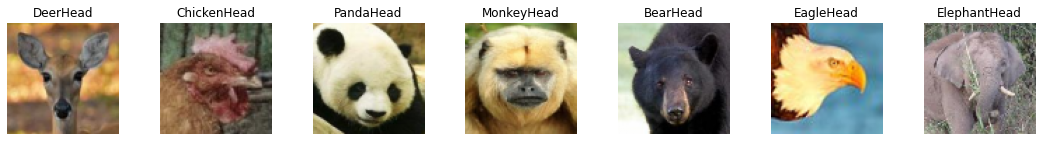

In [16]:
# Printowanie zdjęć (po jednym z kadej klasy)
# (5 pkt.)
# unikalna lista klas
labels = set(data['label'])
 
# Ustawienia matplot lib
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 

# Dla kazdego utworzonego wcześniej pustego okienka na zdjęcie oraz podpis pod nim:
for ax, label in zip(axes, labels):

    # W miejscu komentarza któreś ze zdjęć danej klasy
    ax.imshow(data['data'][data['label'].index(label)])
    ax.axis('off')
    ax.set_title(label)

In [17]:
# Utwórz zbiór cech oraz klas
# (pkt.)
X = data['data']
y = data['label']

In [18]:
# (2 pkt.)
from sklearn import datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=1, stratify=y)

# Podziel zbiory na treningowy oraz testowy za pomocą gotowej funkcji (poprzednie zajęcia)

In [19]:
# (5 pkt.)
import pandas as pd
pd.DataFrame(Counter(y_train).items(), columns=['Model', 'Ilość'])
# Pokaz za przy pomocy pandas i matplotlib wykresy, na którym widoczna będzie ilość próbek dla kazdej klasy (czy zbior jest zbalansowany?)
# Utwórz osobne wykresy dla train i test

,Model,Ilość
0,DeerHead,165
1,BearHead,161
2,PandaHead,189
3,ChickenHead,160
4,MonkeyHead,160
5,EagleHead,161
6,ElephantHead,160


In [20]:
# Jedynie uruchomić - nie zmieniać 
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Konwertuje RGB do Gray
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Hog features - przyjmuje obrazy juz z 1 channel-em
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [21]:

# (5 pkt.)

# Aby dane mogły być danymi wejściowymi do modelu
# Nalezy najpierw:
#  1. Przetransponować je na skalę szarości
#  2. "Usunąć ze zdjęcia nadmiar szczegółów" za pomocą HOG
#  3. Znormalizować dane

X_train_gray = grayify.fit_transform(x_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

SyntaxError: incomplete input (3203664977.py, line 13)

In [22]:
# (5 pkt.)

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
# Wytrenuj model
sgd_clf.fit(X_train_prepared, y_train)

###

NameError: name 'X_train_prepared' is not defined

In [ ]:
# (5 pkt.)

### Zmodyfikuj zbiór testowy, aby był tak samo zmodyfikowany jak zbiór treningowy i dokonaj predykcji

In [ ]:
# (5 pkt.)

## precision, recall, f1, confusion_matrix, Accuracy

In [ ]:
# (10 pkt.)

## Znajdź w sieci 10 obrazków zwierząt, a następnie dokonaj na nich predykcji wcześniej wytrenowanym modelem